Import all the packages

In [81]:

import numpy as np
import matplotlib.pyplot as plt
import io
import SurfaceTopography.Uniform.GeometryAnalysis as CAA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy import interpolate
from ContactMechanics import PeriodicFFTElasticHalfSpace, FreeFFTElasticHalfSpace
from SurfaceTopography import Topography
from SurfaceTopography import make_sphere
from ContactMechanics.Factory import make_system
from ContactMechanics.Systems import NonSmoothContactSystem
from ContactMechanics.Tools.Logger import screen

Fixed Parameters

In [82]:
sx,sy= 4.8,4.8
Es =  1/np.pi #MPa
nu = 0.25
R = 1

Simulation Code
Inputs: Number of rays (user defined), amplitudes (user defined), discretization (user defined), exponent of radius (user defined)
Returns: System of user defined topography, system of Hertzian topography

In [83]:
def simulate(rays,amplitudes,n,p):
    nx, ny = n,n
    sphere = make_sphere(R, (nx, nx), (sx, sy),
        centre=(sx / 2, sy / 2), kind="paraboloid", )

    x, y = sphere.positions()
    x -= sx / 2
    y -= sy /2
    radius = np.sqrt(x ** 2 + y ** 2)

    #theta_out = np.zeros((nx,ny))
    #theta = np.arctan(y/x, out = theta_out, where = x!=0 )
    theta = np.arctan2(y,x)
    #h_m = 1/np.pi
    substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
    #r = np.sqrt((x*x)+(y*y))
    #h_m = r*r/(2*R)
    topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
    
    radial_waves = Topography((radius**p)*amplitudes*(np.cos(rays*theta)), physical_sizes=(sx,sy))
    topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))

    system1 = make_system(substrate, topography1)
    system2 = make_system(substrate, topography)
    gtol = 1e-6
    penetration = 1.2
    sol1 = system1.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    sol2 = system2.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    u = system1.displacements = sol1.x
    gap = system1.compute_gap(u, penetration)

    force = - system1.substrate.evaluate_force(u)
    pressures = force[system1.substrate.local_topography_subdomain_slices] \
            / system1.surface.area_per_pt

 
            
    return system1,system2

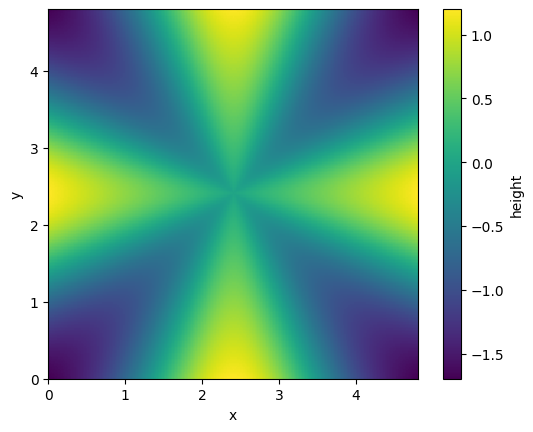

In [85]:
amplitudes = 0.5
rays = 4
p=1
nx, ny = 256,256
sphere = make_sphere(R, (nx, nx), (sx, sy),
centre=(sx / 2, sy / 2), kind="paraboloid", )
x, y = sphere.positions()
x -= sx / 2
y -= sy /2
radius = np.sqrt(x ** 2 + y ** 2)

#theta_out = np.zeros((nx,ny))
#theta = np.arctan(y/x, out = theta_out, where = x!=0 )
theta = np.arctan2(y,x)
#h_m = 1/np.pi
substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
#r = np.sqrt((x*x)+(y*y))
#h_m = r*r/(2*R)
topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
    
radial_waves = Topography((radius**1)*amplitudes*(np.cos(rays*theta)), physical_sizes=(sx,sy))
topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))


fig, ax = plt.subplots()

X, Y = np.meshgrid(np.arange(nx+1) * sx/nx, np.arange(ny+1) * sy/ny, indexing='ij') 
pcm = ax.pcolormesh(X,Y, radial_waves.heights())
cb = plt.colorbar(pcm,ax= ax, label= "height")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

Text(0.5, 0, 'heights')

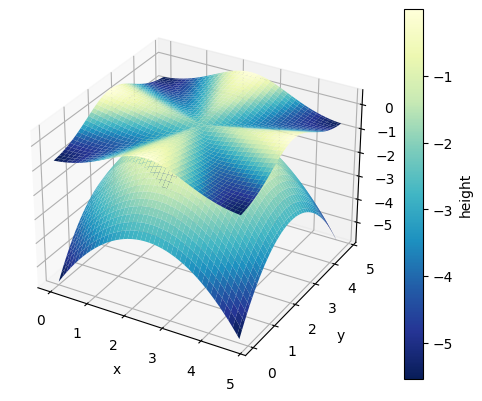

In [94]:
amplitudes = 0.2
rays = 4
p=0
nx, ny = 256,256
sphere = make_sphere(R, (nx, nx), (sx, sy),
centre=(sx / 2, sy / 2), kind="paraboloid", )
x, y = sphere.positions()
x -= sx / 2
y -= sy /2
radius = np.sqrt(x ** 2 + y ** 2)

#theta_out = np.zeros((nx,ny))
#theta = np.arctan(y/x, out = theta_out, where = x!=0 )
theta = np.arctan2(y,x)
#h_m = 1/np.pi
substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
#r = np.sqrt((x*x)+(y*y))
#h_m = r*r/(2*R)
topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
    
radial_waves = Topography((radius**1)*amplitudes*(np.cos(rays*theta)), physical_sizes=(sx,sy))
topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = np.arange(0, nx, 1)*sx/nx
y = np.arange(0, ny, 1)*sy/ny
X,Y = np.meshgrid(x,y)

pcm = ax.plot_surface(X,Y,topography.heights(), cmap=plt.cm.YlGnBu_r)
pcm1 = ax.plot_surface(X,Y,radial_waves.heights(), cmap=plt.cm.YlGnBu_r)
cb = plt.colorbar(pcm,ax= ax, label= "height")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("heights")

Postprocessing Code
Inputs: systm1 (Obtained from running the simulate function), number of rays (user defined), discretization (user defined)
Returns: Minimum radius, maximum radius

In [52]:
def postprocess(system1,rays,n):
    nx,ny = n,n
    contact_area1 = system1.contact_zone
    #contact_area2 = system2.contact_zone
    Nx, Ny = contact_area1.shape
    x,y = np.mgrid[:Nx, :Ny]
    
    
    #iper = CAA.inner_perimeter_area(contact_area, True, stencil=CAA.nn_stencil)
    #ax.plot(x[iper], y[iper], ".r", label="inner_perimeter, nn")
    #iper = CAA.inner_perimeter_area(contacting_points, True, stencil=CAA.nnn_stencil)
    #ax.plot(x[iper], y[iper], "xr", label="inner_perimeter, nnn")
    mask_min = 25
    mask_max = 40
    oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nn_stencil)
    oper[(mask_min*rays):nx//2,(mask_min*rays):ny//2]=False  
    oper[nx//2:(mask_max*rays), ny//2:(mask_max*rays)] = False
    oper[(mask_min*rays):nx//2, ny//2:(mask_max*rays)] = False
    oper[nx//2:(mask_max*rays),(mask_min*rays):ny//2]=False
    #sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nn_stencil)
    
    
    
    X = x[oper]
    Y = y[oper]
    center = [np.mean(X), np.mean(X)]
    
    distances = []
    for i in range(len(X)):
        distance = np.sqrt((X[i] - center[0])**2 + (Y[i] - center[1])**2)
        distances.append(distance)
    min_distance = min(distances)
    max_distance = max(distances)
    return min_distance,max_distance 

Creates delta a vs delta h plot:
Input: Minimum limit of amplitude (user defined), maximum limit of amplitude (user defined), number of rays (user defined), discretization (user defined)

In [53]:
def a_vs_h(min_amplitude, max_amplitude, rays, discretization,p):
    if(discretization==256):
        t=10
    else:
        t=6
    amplitudes = np.linspace(min_amplitude,max_amplitude,t)
    distor = np.zeros(len(amplitudes))
    amp = np.zeros(len(amplitudes))
    for i in range(len(amplitudes)):
        #print(amplitudes[i])
        system,Hertzsystem = simulate(rays,amplitudes[i],discretization,p)
        min_distance,max_distance = postprocess(system,rays,discretization)
        distor[i]=max_distance-min_distance
        amp[i] = amplitudes[i]
    plt.loglog(amp,distor,"-+", label="$r\cos(n\Theta)$")
    plt.plot(amp, 140*(amp**1), color='red', label='$\propto x^1$')
    plt.plot(amp, 85*(amp**0.5), color='blue', label='$\propto x^{0.5}$')
    plt.title("$\Delta$a vs $\Delta$h with h varying from {:.2f}-{:.2f}".format(min_amplitude,max_amplitude))    
    plt.xlabel("Roughness $\Delta$h")
    plt.ylabel("$\Delta$a")
    plt.legend()

Creates contact perimeter plots:
Inputs: system1(Obtained from running simulate function), system1(Obtained from running simulate function), No. of rays (user defined), Discretization (user defined), amplitude (user defined) 

In [87]:
def Contact_Perimeter(system1,system2,n,amplitude):
    nx,ny = n,n
    contact_area1 = system1.contact_zone
    contact_area2 = system2.contact_zone
    Nx, Ny = contact_area1.shape
    x,y = np.mgrid[:Nx, :Ny]
    
    
    mask_min = 25
    mask_max = 40
    oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nnn_stencil)
    #oper[(mask_min*rays):nx//2,(mask_min*rays):ny//2]=False 
    #oper[nx//2:(mask_max*rays), ny//2:(mask_max*rays)] = False
    #oper[(mask_min*rays):nx//2, ny//2:(mask_max*rays)] = False
    #oper[nx//2:(mask_max*rays),(mask_min*rays):ny//2]=False
    #sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nnn_stencil)
    fig, ax = plt.subplots()
    ax.imshow(contact_area1, cmap="Greys")
    ax.set_title("Contact Perimeter")
    ax.plot(x[oper], y[oper], ".b", mfc="none",label="$\Delta$h={:.2f}".format(amplitude))
    #ax.plot(x[sper], y[sper], ".r", mfc="none")
    ax.set_axis_off()
    #ax.set_xlabel("x values in units of contact radius in absence of waviness")
    #ax.set_ylabel("y values in units of contact radius in absence of waviness")
    ax.set_aspect(1)
    #ax.legend()

Creates delta vs number of rays plot:
Input: Amplitude (user defined)

In [20]:
def a_vs_rays(amplitude,p):
    rays = [4,8,10,12,14,16]
    distor = np.zeros(len(rays))
    r = np.zeros(len(rays))
    for i in range(len(rays)):
        N = 64
        system,Hertzsystem = simulate(rays[i],amplitude,N*rays[i],p)
        min_distance,max_distance = postprocess(system,rays[i],N*rays[i])
        distor[i] = max_distance-min_distance
        r[i] = rays[i] 
    
    return distor,r 
    #plt.plot(r,distor,"-+", label = 'simulated line')
    #plt.plot(r, (r**1.5), color='red', label='k$x^1.5$ line')
    #plt.title("Relationship of $\Delta$a with number of rays at a fixed amplitude")    
    #plt.xlabel("Number of rays")
    #plt.ylabel("$\Delta$a")
    #plt.legend()


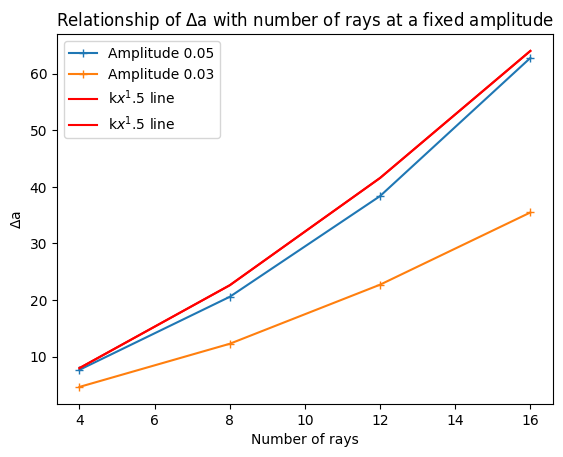

In [25]:
distor1,r1 = a_vs_rays(0.05)
distor2,r2 = a_vs_rays(0.03)
plt.plot(r1,distor1,"-+", label = 'Amplitude 0.05')
plt.plot(r2,distor2,"-+", label = 'Amplitude 0.03')
plt.plot(r1, (r1**1.5), color='red', label='k$x^1.5$ line')
plt.plot(r2, (r2**1.5), color='red', label='k$x^1.5$ line')
plt.title("Relationship of $\Delta$a with number of rays at a fixed amplitude")    
plt.xlabel("Number of rays")
plt.ylabel("$\Delta$a")
plt.legend()

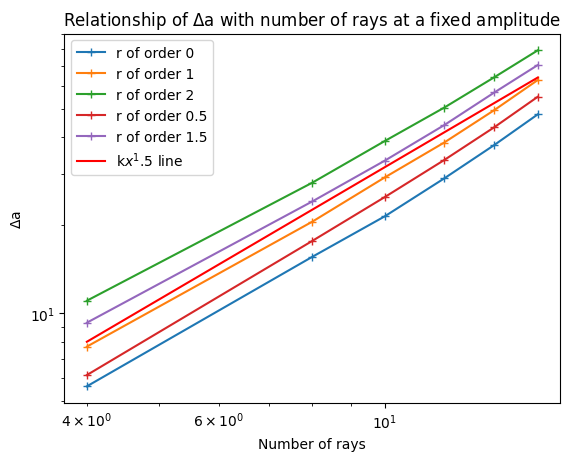

In [59]:
distor0,r0 = a_vs_rays(0.05,0)
distor1,r1 = a_vs_rays(0.05,1)
distor2,r2 = a_vs_rays(0.05,2)
distor3,r3 = a_vs_rays(0.05,0.5)
distor4,r4 = a_vs_rays(0.05,1.5)
plt.loglog(r0,distor0,"-+", label = 'r of order 0')
plt.loglog(r1,distor1,"-+", label = 'r of order 1')
plt.loglog(r2,distor2,"-+", label = 'r of order 2')
plt.loglog(r3,distor3,"-+", label = 'r of order 0.5')
plt.loglog(r4,distor4,"-+", label = 'r of order 1.5')
plt.loglog(r0, (r0**1.5), color='red', label='k$x^1.5$ line')
plt.title("Relationship of $\Delta$a with number of rays at a fixed amplitude")    
plt.xlabel("Number of rays")
plt.ylabel("$\Delta$a")
plt.legend()

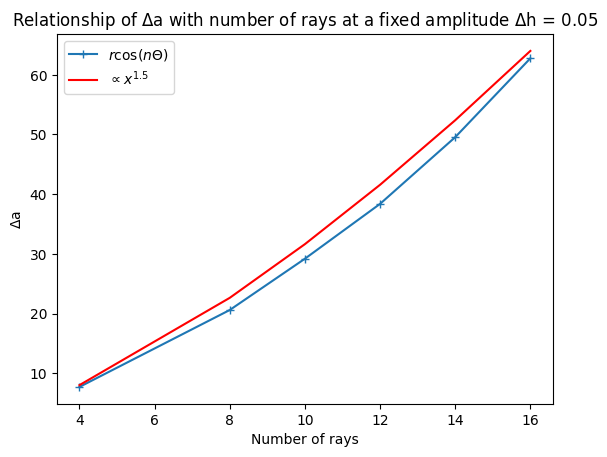

In [46]:
#distor0,r0 = a_vs_rays(0.05,0)
distor1,r1 = a_vs_rays(0.05,1)
#distor2,r2 = a_vs_rays(0.05,2)
#distor3,r3 = a_vs_rays(0.05,0.5)
#distor4,r4 = a_vs_rays(0.05,1.5)
#plt.loglog(r0,distor0,"-+", label = 'r of order 0')
plt.plot(r1,distor1,"-+", label = "$r\cos(n\Theta)$")
#plt.loglog(r2,distor2,"-+", label = 'r of order 2')
#plt.loglog(r3,distor3,"-+", label = 'r of order 0.5')
#plt.loglog(r4,distor4,"-+", label = 'r of order 1.5')
plt.plot(r1, (r1**1.5), color='red', label='$\propto x^{1.5}$')
plt.title("Relationship of $\Delta$a with number of rays at a fixed amplitude $\Delta$h = 0.05")    
plt.xlabel("Number of rays")
plt.ylabel("$\Delta$a")
plt.legend()

Example code with 4 rays

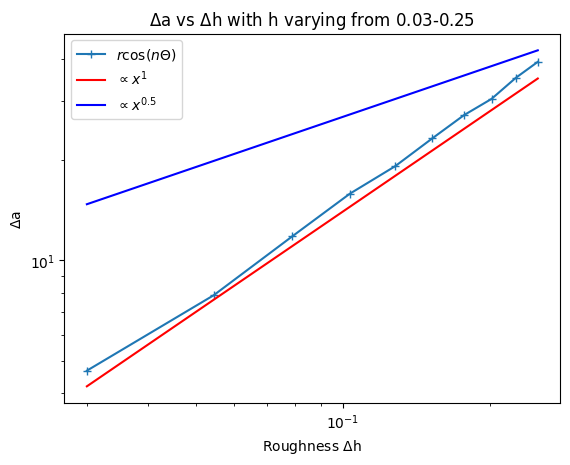

In [47]:
a_vs_h(0.03,0.25,4,256,1)
#user_system_max,Hertzsys = simulate(4,0.25,256,1)
#user_system_min,Hertzsys = simulate(4,0.03,256,1)
#Contact_Perimeter(user_system_max,Hertzsys,256,0.25)
#Contact_Perimeter(user_system_min,Hertzsys,256,0.03)

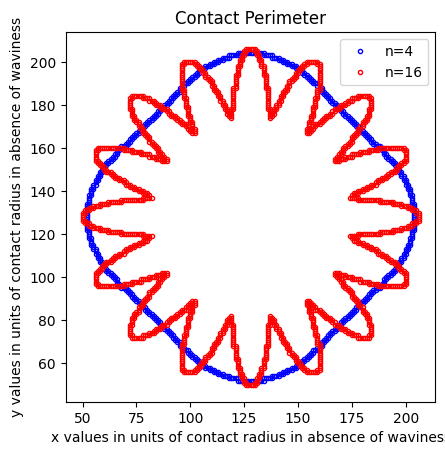

In [40]:
user_system_max,Hertzsys = simulate(4,0.08,256,1)
user_system_max1,Hertzsys1 = simulate(16,0.08,256,1)
Contact_Perimeter(user_system_max,user_system_max1,256,0.08)
#Contact_Perimeter(user_system_max1,Hertzsys1,16,1024,0.08)

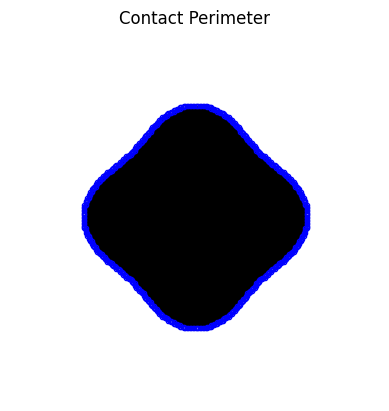

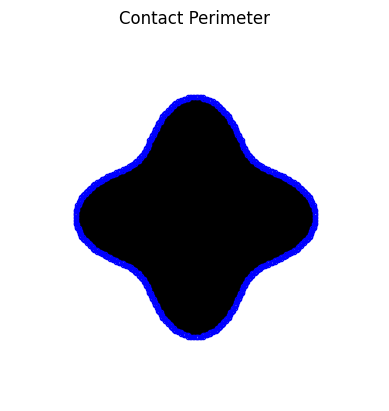

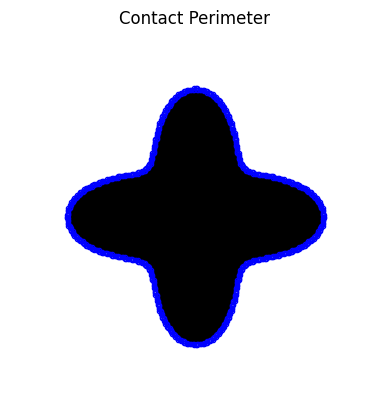

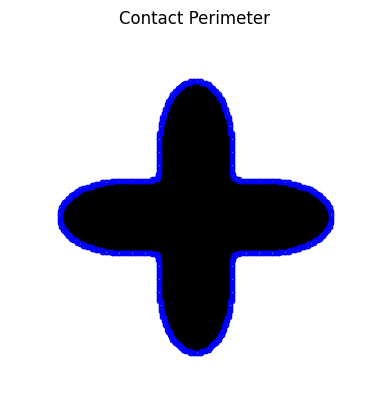

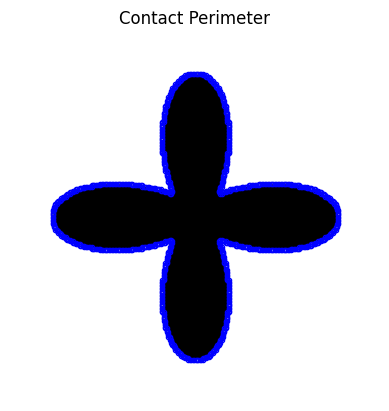

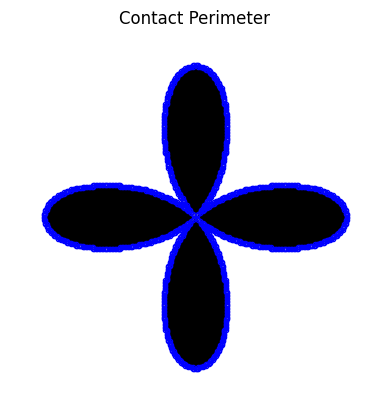

In [88]:
amplitudes = np.linspace(0.1,0.5,6)
for a in amplitudes:
    user_system_max1,Hertzsys1 = simulate(4,a,256,1)
    Contact_Perimeter(user_system_max1,Hertzsys1,256,a)


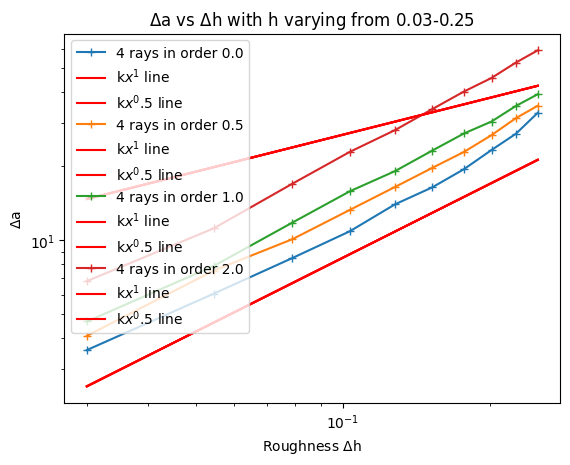

In [51]:
a_vs_h(0.03,0.25,4,256,0)
a_vs_h(0.03,0.25,4,256,0.5)
a_vs_h(0.03,0.25,4,256,1)
a_vs_h(0.03,0.25,4,256,2)

